In [7]:
import logging
import collections
import os
import pathlib
import re
import string
import sys
import tempfile
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pyarrow.parquet as pa

import tensorflow as tf
import tensorflow.keras as k
import ShapeChecker
import einops
import tensorflow_text
import tensorflow_datasets as tfds
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

In [8]:
tf.get_logger().setLevel('ERROR')

In [9]:
table = pa.read_table('./data/to_spanish.parquet')
df = table.to_pandas()
df.head()
df = df.iloc[:350000,:]
len(df)

350000

In [10]:
table_val = pa.read_table('./data/to_spanish_val.parquet')
df_val = table_val.to_pandas()
df_val.head()

,translation
0,{'en': 'I don't even remember what the fight w...
1,{'en': 'Here are the sites of each of those th...
2,"{'en': 'I'm the man who killed Blackbeard.', '..."
3,"{'en': 'Don't get smart.', 'es': 'No te hagas ..."
4,{'en': 'Is there an exact moment in the life o...


In [11]:
en_train_ds = np.array([row['en'] for row in df['translation']])
sp_train_ds = np.array([row['es'] for row in df['translation']])

In [12]:
en_val_ds = np.array([row['en'] for row in df_val['translation']])
sp_val_ds = np.array([row['es'] for row in df_val['translation']])

In [13]:
# def load_data(dir):
#   pwd = pathlib.Path.cwd()
#   english_train = pathlib.Path(os.path.join(pwd, 'data/en_sp/english.train.txt'))
#   spanish_train = pathlib.Path(os.path.join(pwd, 'data/en_sp/spanish.train.txt'))
#   english_val = pathlib.Path(os.path.join(pwd, 'data/en_sp/english.val.txt'))
#   spanish_val = pathlib.Path(os.path.join(pwd, 'data/en_sp/spanish.val.txt'))
  
#   en_train_text = english_train.read_text(encoding='utf-8')
#   sp_train_text = spanish_train.read_text(encoding='utf-8')
#   en_val_text = english_val.read_text(encoding='utf-8')
#   sp_val_text = spanish_val.read_text(encoding='utf-8')

#   sp_train_lines = sp_train_text.splitlines()
#   en_train_lines = en_train_text.splitlines()
#   sp_val_lines = sp_val_text.splitlines()
#   en_val_lines = en_val_text.splitlines()
  
  
#   sp_train_ds = np.array([line for line in sp_train_lines])
#   en_train_ds = np.array([line for line in en_train_lines])
#   sp_val_ds = np.array([line for line in sp_val_lines])
#   en_val_ds = np.array([line for line in en_val_lines])
  

#   return sp_train_ds, en_train_ds, sp_val_ds, en_val_ds

In [14]:
# sp_train_ds, en_train_ds, sp_val_ds, en_val_ds = load_data(data_dir)


In [15]:
BUFFER_SIZE = 8000
BATCH_SIZE = 64

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((en_train_ds, sp_train_ds))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((en_val_ds, sp_val_ds))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [16]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'Excuse me.' b"I don't like it." b'However, the condoms produced.'
 b'In its 3-year action plan of consumer policy in the EC (1990-1992) the Commission emphasized its aim to rapidly and radically improve the standards of consumer informa tion about the use of consumer products in order to prepare consumers for the full implementation of the internal market by 1993.'
 b"- I told you, it's just a scrape."], shape=(5,), dtype=string)

tf.Tensor(
[b'Disc\xc3\xbalpeme.' b'No me gusta.'
 b'Sin embargo, de los condones s\xc3\xad.'
 b'En su Plan trienal de acci\xc3\xb3n sobre pol\xc3\xadtica de los consumidores en la CE (1990-1992), la Comisi\xc3\xb3n hizo hincapi\xc3\xa9 en su objetivo de mejorar de forma acelerada y radical los niveles de informaci\xc3\xb3n al consumidor en relaci\xc3\xb3n con la utilizaci\xc3\xb3n de productos de consumo, para preparar al consumidor ante la plena realizaci\xc3\xb3n del mercado interior en 1993.'
 b'- Ya te lo dije, es solo un rasgu\xc3\xb1o.'],

In [17]:
example_text = tf.constant('Hello Tom, How are you today?')

print(example_text.numpy())
print(tensorflow_text.normalize_utf8(example_text, 'NFKD').numpy())

b'Hello Tom, How are you today?'
b'Hello Tom, How are you today?'


In [18]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tensorflow_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [19]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

Hello Tom, How are you today?
[START] hello tom ,  how are you today ? [END]


In [20]:
max_vocab_size = 10000

spanish_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [21]:
max_vocab_size = 10000

english_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [22]:
spanish_text_processor.adapt(train_raw.map(lambda context, target: target))

# Here are the first 10 words from the vocabulary:
spanish_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'de', ',', 'la', 'que', 'el']

In [23]:
english_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
english_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', ',', 'of', 'to', 'and']

In [24]:
example_tokens = english_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 676, 31, 4, 3], [2, 13, 51, 56, 18, 4, 3],
 [2, 297, 6, 5, 8873, 1578, 4, 3]]>

In [25]:
context_vocab = np.array(english_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] excuse me . [END]'

Text(0.5, 1.0, 'Mask')

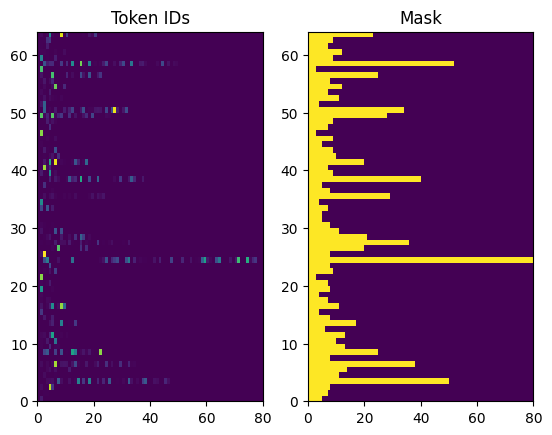

In [26]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [27]:
def process_text(context, target):
  context = english_text_processor(context).to_tensor()
  target = spanish_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [28]:

for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy())

[   2    1   16  262    8 7275    5 1306    7   77]

[   2    1   30 1124   23 5938    7  958    5    7]
[   1   30 1124   23 5938    7  958    5    7 7522]


In [29]:
UNITS = 256

In [30]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    # shape_checker = ShapeChecker()
    # shape_checker.shapecheck(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    # shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    # shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [31]:
# Encode the input sequence.
encoder = Encoder(english_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 45)
Encoder output, shape (batch, s, units): (64, 45, 256)


In [32]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    # shape_checker = ShapeChecker()

    # shape_checker(x, 'batch t units')
    # shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    # shape_checker(x, 'batch t units')
    # shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    # shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [33]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(spanish_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 45, 256)
Target sequence, shape (batch, t, units): (64, 52, 256)
Attention result, shape (batch, t, units): (64, 52, 256)
Attention weights, shape (batch, t, s):    (64, 52, 45)


In [34]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.9999999 , 0.9999999 , 1.        ,
       1.        , 0.9999999 , 1.        , 1.        , 1.        ,
       0.99999994, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ], dtype=float32)

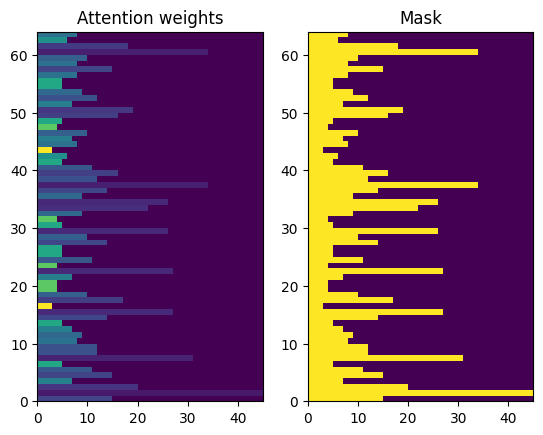

In [35]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

In [36]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [37]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  # shape_checker = ShapeChecker()
  # shape_checker(x, 'batch t')
  # shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  # shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  # shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  # shape_checker(x, 'batch t units')
  # shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  # shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [38]:
decoder = Decoder(spanish_text_processor, UNITS)

In [39]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 45, 256)
input target tokens shape: (batch, t) (64, 52)
logits shape shape: (batch, target_vocabulary_size) (64, 52, 10000)


In [40]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [41]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [42]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

In [43]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'haciendo boton belleza escolar conspiracion atraccion planteado operadores ana osos',
       b'peleando casado capacidad danos efectivas vertical intergubernamentales uganda carmen solucionar',
       b'cambie presidencial genetica muestra desea poderes comite ibid suelen presa'],
      dtype=object)

In [44]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [45]:
model = Translator(UNITS, english_text_processor, spanish_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 45)
Target tokens, shape: (batch, t) (64, 52)
logits, shape: (batch, t, target_vocabulary_size) (64, 52, 10000)


In [46]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [47]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [48]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [49]:
vocab_size = 1.0 * english_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 9.2103405, 'expected_acc': 0.0001}

In [50]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 17s 464ms/step - loss: 9.2102 - masked_acc: 4.8309e-05 - masked_loss: 9.2102


{'loss': 9.210203170776367,
 'masked_acc': 4.830917896470055e-05,
 'masked_loss': 9.210203170776367}

In [65]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
100/100 [==============================] - 406s 4s/step - loss: 1.9971 - masked_acc: 0.5896 - masked_loss: 1.9971 - val_loss: 2.2961 - val_masked_acc: 0.5505 - val_masked_loss: 2.2961
Epoch 2/100
100/100 [==============================] - 332s 3s/step - loss: 1.9607 - masked_acc: 0.5945 - masked_loss: 1.9607 - val_loss: 2.2688 - val_masked_acc: 0.5506 - val_masked_loss: 2.2688
Epoch 3/100
100/100 [==============================] - 361s 4s/step - loss: 1.9620 - masked_acc: 0.5921 - masked_loss: 1.9620 - val_loss: 2.2861 - val_masked_acc: 0.5509 - val_masked_loss: 2.2861
Epoch 4/100
100/100 [==============================] - 386s 4s/step - loss: 1.9541 - masked_acc: 0.5936 - masked_loss: 1.9541 - val_loss: 2.3126 - val_masked_acc: 0.5493 - val_masked_loss: 2.3126
Epoch 5/100
100/100 [==============================] - 396s 4s/step - loss: 1.9703 - masked_acc: 0.5940 - masked_loss: 1.9703 - val_loss: 2.3083 - val_masked_acc: 0.5449 - val_masked_loss: 2.3083
Epoch 6/100
100/100 

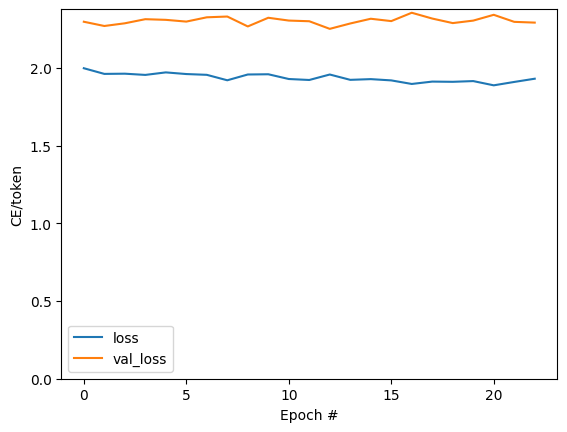

In [66]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

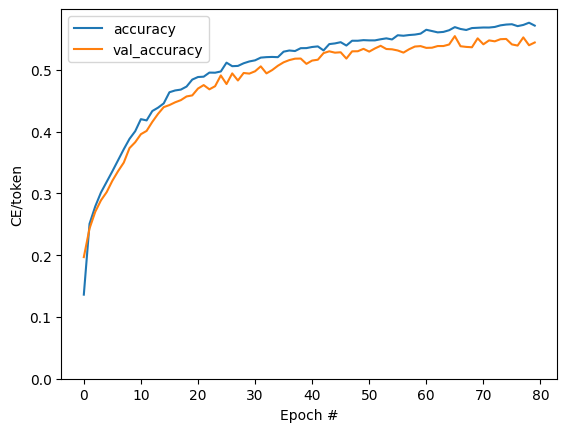

In [53]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [67]:
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [68]:
result = model.translate(['Are you still home?']) # ¿Todavía está en casa?
result[0].numpy().decode()

'¿ sigues en casa ? '

In [69]:
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

C:\Users\SamuelMcmurray\AppData\Local\Temp\ipykernel_26996\2375050876.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\SamuelMcmurray\AppData\Local\Temp\ipykernel_26996\2375050876.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


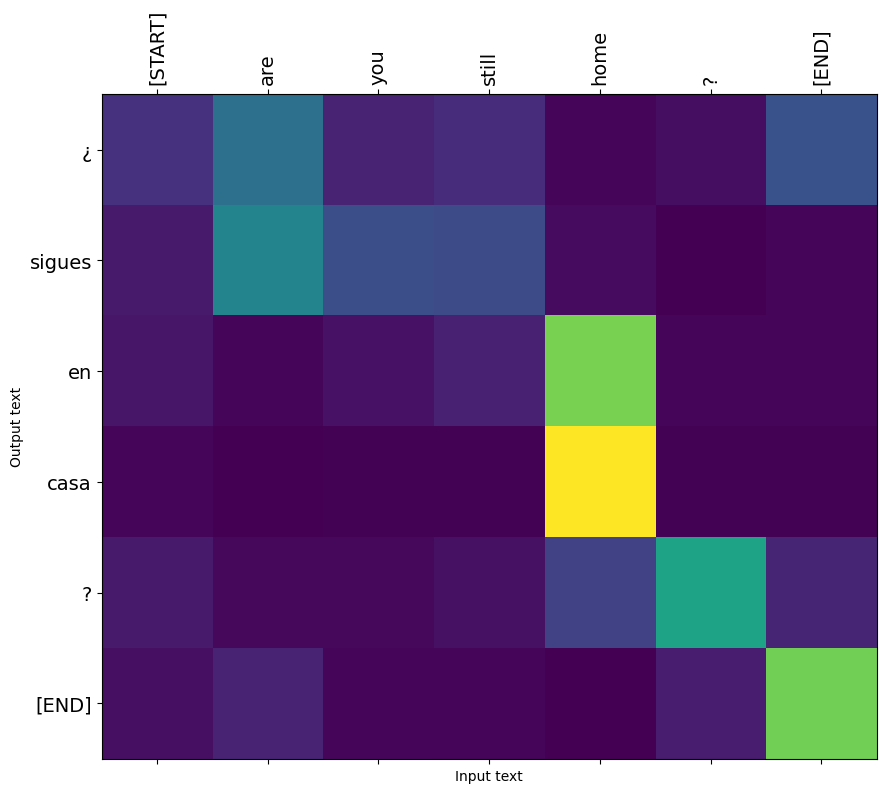

In [70]:
model.plot_attention('Are you still home?') # ¿Todavía está en casa?

C:\Users\SamuelMcmurray\AppData\Local\Temp\ipykernel_26996\2375050876.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\SamuelMcmurray\AppData\Local\Temp\ipykernel_26996\2375050876.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


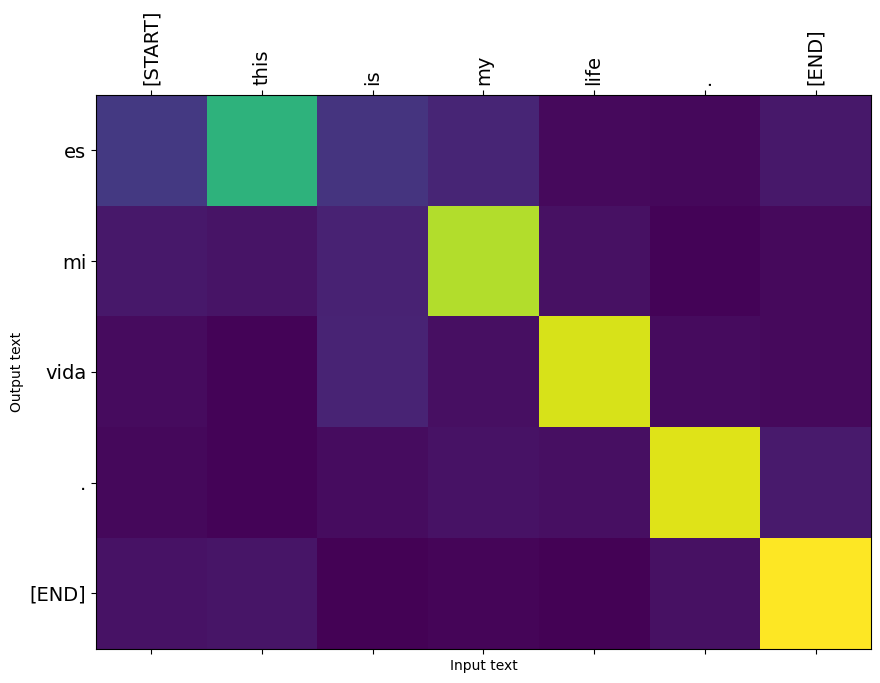

In [71]:
model.plot_attention('This is my life.') # Esta es mi vida.

C:\Users\SamuelMcmurray\AppData\Local\Temp\ipykernel_26996\2375050876.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\SamuelMcmurray\AppData\Local\Temp\ipykernel_26996\2375050876.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


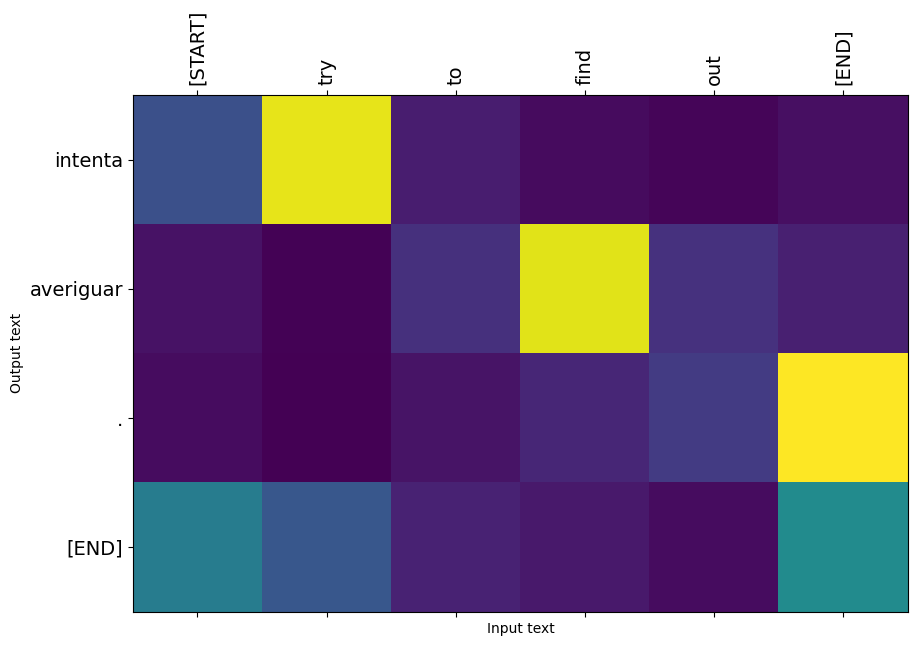

In [72]:
model.plot_attention('Try to find out') # Tratar de descubrir.

In [73]:
long_text = """You will use a small heart disease dataset provided by the UCI Machine Learning Repository. There are several hundred rows in the CSV. Each row describes a patient, and each column describes an attribute. You will use this information to predict whether a patient has heart disease, which is a binary classification task."""

TypeError: str.join() takes exactly one argument (0 given)

C:\Users\SamuelMcmurray\AppData\Local\Temp\ipykernel_26996\2375050876.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\SamuelMcmurray\AppData\Local\Temp\ipykernel_26996\2375050876.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


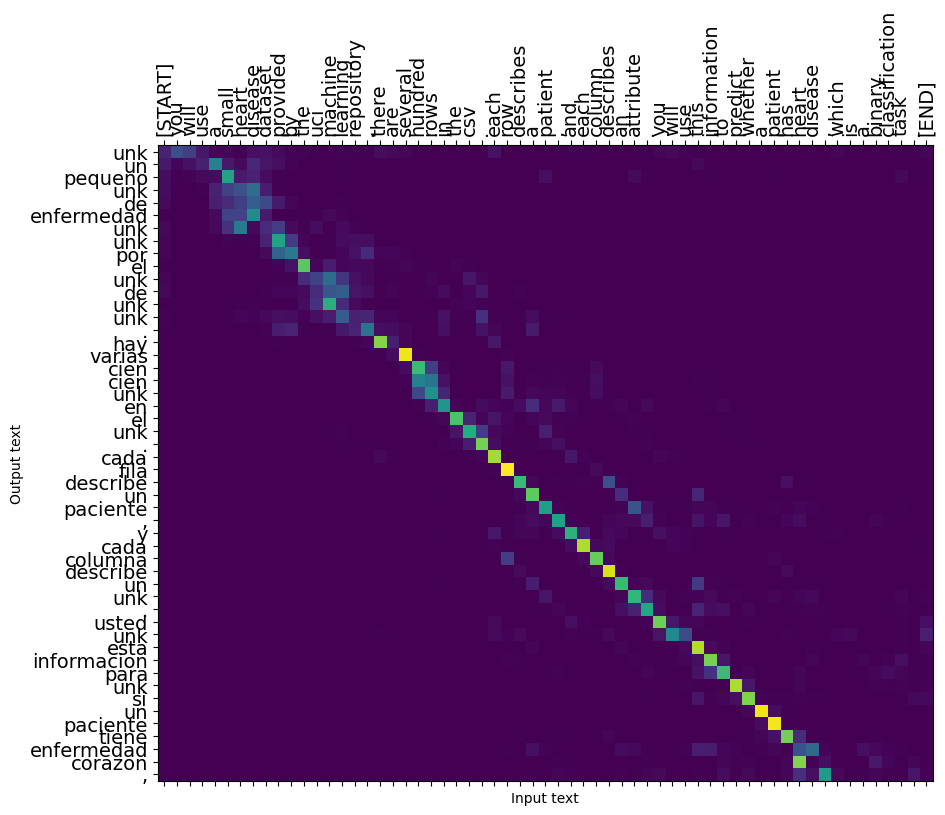

In [74]:
model.plot_attention(long_text)

In [75]:
inputs = [
    "It's really cold here.", # 'Hace mucho frio aqui.'
    "This is my life.", # 'Esta es mi vida.'
    "His room is a mess" # 'Su cuarto es un desastre.'
]

In [76]:
for t in inputs:
  print(model.translate([t])[0].numpy().decode())

print()

esta muy frio aqui . 
es mi vida . 
su habitacion es un asco . 



In [77]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [78]:
export = Export(model)

In [79]:
_ = export.translate(tf.constant(inputs))

In [82]:
result = export.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

esta muy frio aqui .                                             
es mi vida .                                              
su habitacion es un asco .                                            



In [81]:
tf.saved_model.save(export, './models/en_es_translation',
                    signatures={'serving_default': export.translate})

In [83]:
reloaded = tf.saved_model.load('models/en_es_translation')
_ = reloaded.translate(tf.constant(inputs)) #warmup

In [84]:
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

esta muy frio aqui .                                             
es mi vida .                                              
su habitacion es un asco .                                            



In [90]:
converter = tf.lite.TFLiteConverter.from_keras_model(export)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
converter.experimental_enable_resource_variables = True 
tflite_model = converter.convert()
# Save the model.
with open('tflite_models/en_es_translation.tflite', 'wb') as f:
  f.write(tflite_model)

In [99]:
interpreter = tf.lite.Interpreter(model_path='tflite_models/en_es_translation.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']

interpreter.set_tensor(input_details[0]['index'], np.array([inputs[0]]))

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[b'esta muy frio aqui .                                             ']
